In [84]:
#import all the librariys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


Step 1: Exploratory Data Analysis (EDA) and Data Preprocessing Load Dataset.
We will start by loading the dataset and examining its structure.

In [85]:
df=pd.read_csv('retail_sales.csv')
df.head()

,Date,Sales
0,1/1/15 0:00,54.048619
1,1/1/15 1:00,50.161596
2,1/1/15 2:00,55.954939
3,1/1/15 3:00,56.553261
4,1/1/15 4:00,60.487874


In [ ]:
Step 2: Data Cleaning and Preparation
Next, we will check for missing values, handle any inconsistencies.

In [3]:
df.isnull().sum()# in this data set not having any null values.

Date     0
Sales    0
dtype: int64

In [86]:
# Set Date column as an index and convert the date column to a datetime object for easier manipulation.
df.set_index('Date', inplace=True)
df.index=pd.to_datetime(df.index)
# Resample data to get monthly sales
monthly_data = df['Sales'].resample('M').sum()
monthly_data=monthly_data.to_frame()

C:\Users\kishore\AppData\Local\Temp\ipykernel_6936\997432770.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index=pd.to_datetime(df.index)
C:\Users\kishore\AppData\Local\Temp\ipykernel_6936\997432770.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df['Sales'].resample('M').sum()


In [5]:
monthly_data.describe()

,Sales
count,72.000000
mean,73032.887806
std,21143.245941
min,36853.531572
25%,55474.149488
50%,71157.254630
75%,91695.463407
max,107851.188641


Data Visualization:
Visualizing the data helps in understanding trends, seasonality, and anomalies.

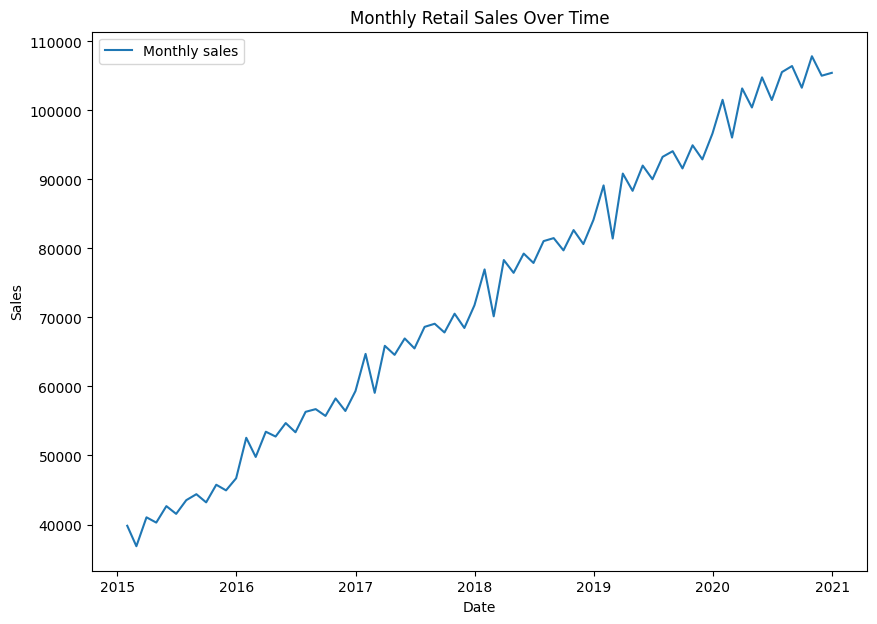

In [87]:
#plot
plt.figure(figsize=(10, 7))
plt.plot(monthly_data, label='Monthly sales')
plt.title('Monthly Retail Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

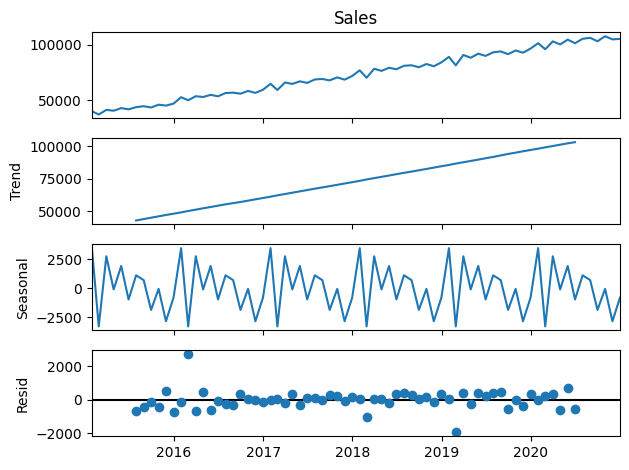

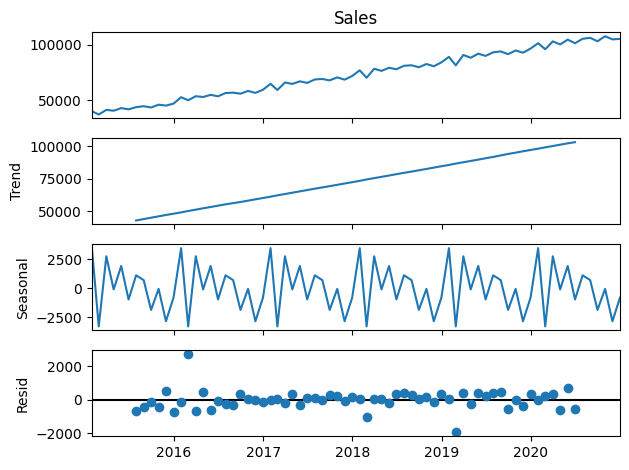

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(monthly_data['Sales'])
result.plot()

In [8]:
# Create a new column for month names to Visualize the sale depending on the month's
monthly_data['Month'] = monthly_data.index.month_name()

In [10]:
monthly_data.head()

,Sales,Month
Date,,
2015-01-31,39816.725116,January
2015-02-28,36853.531572,February
2015-03-31,41041.303060,March
2015-04-30,40278.963454,April
2015-05-31,42663.477214,May


In [12]:
# Group by month and get the max sales for each month
monthly_max_sales=monthly_data.groupby('Month')['Sales'].max()

# Reindex to ensure the months are in the correct order
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
monthly_max_sales = monthly_max_sales.reindex(month_order)

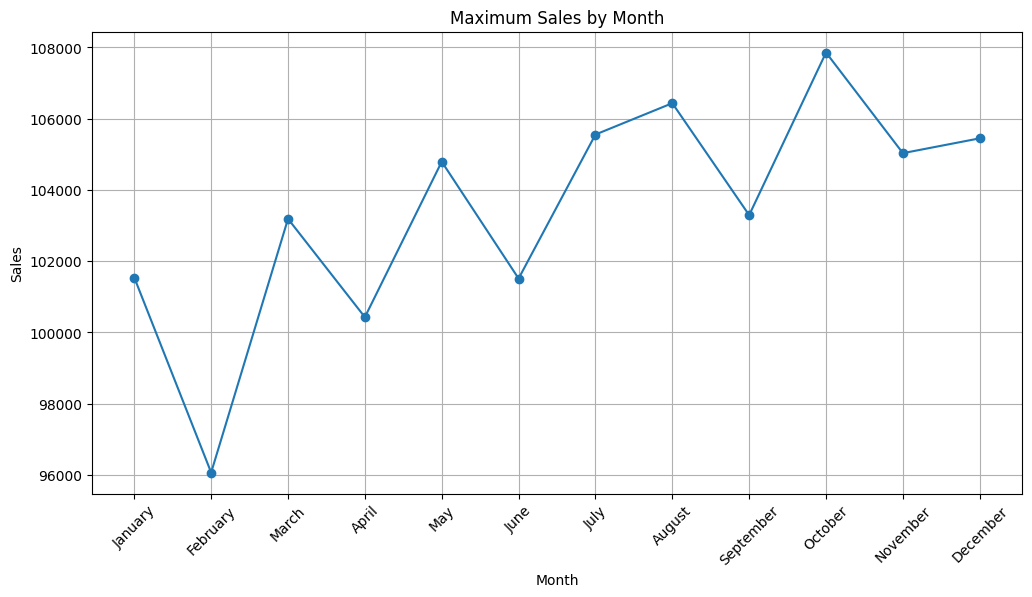

In [13]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_max_sales.index,monthly_max_sales,marker="o")
plt.title('Maximum Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


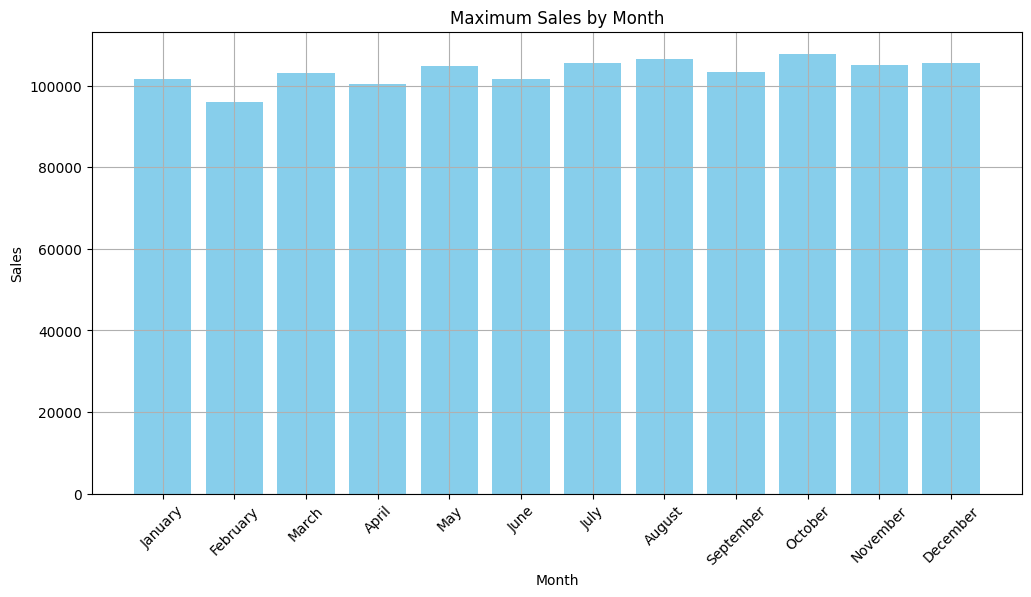

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(monthly_max_sales.index, monthly_max_sales.values, color='skyblue')
plt.title('Maximum Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [16]:
# Identify the date and value of the maximum sales
max_sale_date = monthly_data['Sales'].idxmax()
max_sale_value = monthly_data['Sales'].max()

print(f"Maximum Sales Amount: {max_sale_value} on {max_sale_date}")

Maximum Sales Amount: 107851.1886409 on 2020-10-31 00:00:00


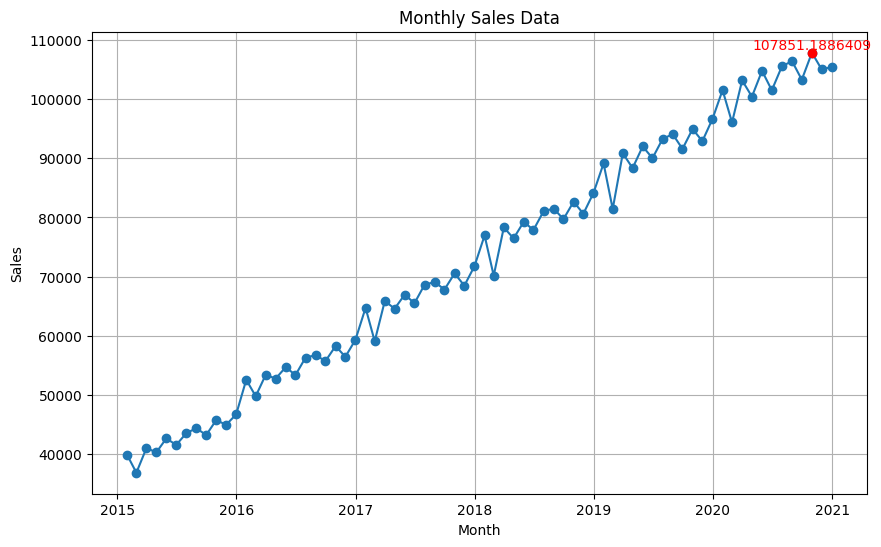

In [18]:
# Plotting the sales data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['Sales'], marker='o', linestyle='-')
# Highlight the maximum sales point
plt.scatter([max_sale_date], [max_sale_value], color='red', zorder=5)
plt.text(max_sale_date, max_sale_value, f'{max_sale_value}', color='red', ha='center', va='bottom')

# Adding titles and labels
plt.title('Monthly Sales Data')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)

# Show the plot
plt.show()

Step 3: *Building and Training the Deep Learning Model for Model Selection.

*For this task, we will use Long Short-Term Memory (LSTM) networks, which are well-suited for time series forecasting.

*Data Preparation for LSTM, LSTM models require input data to be in the form of sequences. We will create sequences of a specified length (e.g., 12 months) to predict the next month's sales.

In [ ]:
data=monthly_data.drop('Month',axis=1)#drop the month column
data.values.reshape(-1,1)#convert the data into np.array


In [61]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Normalize the data
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(data)

# Create sequences
SEQ_LENGTH = 12
X, y = create_sequences(sales_scaled, SEQ_LENGTH)# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=48)

In [49]:
X_test.shape

(12, 12, 1)

Train a Model with Early Stopping
 We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

In [71]:
#Building the LSTM Model We will build an LSTM model using TensorFlow
model=tf.keras.Sequential([
    LSTM(60,activation='relu',input_shape=(12,1),return_sequences=True),#hidden layer 1
    Dropout(0.3),
    LSTM(60,activation='relu',return_sequences=True),#hidden layer 2
    Dropout(0.3),
    LSTM(60,activation='relu'),#hidden layer 3
    Dropout(0.3),
    Dense(1)])#output

# Compile the model
model.compile(optimizer='Adam', loss='mse',)
model.summary()
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.001 # minimium amount of change to count as an improvement,
                               ,patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# Train the model
history = model.fit(X_train, y_train, epochs=80, batch_size=20,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping,reduce_lr])
    

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                       │ (None, 12, 60)              │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 12, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_51 (LSTM)                       │ (None, 12, 60)              │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 12, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,021 (285.24 KB)

 Trainable params: 73,021 (285.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.4629 - val_loss: 0.2255 - learning_rate: 0.0010
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3808 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3467 - val_loss: 0.1519 - learning_rate: 0.0010
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2903 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1617 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0682 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0537 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0628 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 9/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0239 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 10/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0023
Test loss: 0.0022801177110522985


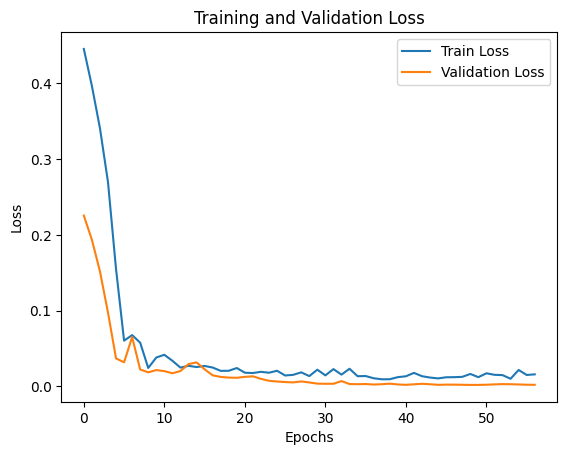

In [72]:
# Plot the training and validation loss
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [73]:
#Let's Predict the model with test data
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


In [74]:
y_pred

array([[0.4861448 ],
       [0.26956394],
       [0.38020578],
       [0.3331451 ],
       [0.32191232],
       [0.86734486],
       [0.35459983],
       [0.28240645],
       [0.31314367],
       [0.91613483],
       [0.47396615],
       [0.43481576]], dtype=float32)

In [ ]:
#save the model
model.save("lstm_model.h5")

In [75]:
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

RMSE: 3390.179949953554
MAE: 2925.714555679165
R2 Score: 0.9603427236562436


Interpretation of the Results:
1.RMSE of 3390.18: This means that, on average, the model's predictions are off by approximately 3390.18 units.
2.MAE of 2925.71: This indicates that the average absolute error between the predicted and actual values is about 2925.71 units.
3.R² Score of 0.9603: This indicates that about 96.03% of the variance in the target variable is explained by the model, which suggests a very good fit.

Summary:
1.The metrics suggest that this model performs well, with high R² and reasonably low RMSE and MAE values.
2.However, the actual interpretation of RMSE and MAE values should be done in the context of this specific dataset.
3.The high R² score indicates that the model explains the variance in the target variable quite well.